In [41]:
!pip install --upgrade scikit-learn



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 93.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


In [2]:
!pip install pandas numpy matplotlib seaborn scipy

In [3]:
!pip install scikit-surprise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 7.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357266 sha256=e2f010bf3da9e8b055f4aa709460a45ff92b2a64289634e9a1b44cab8402a1e4
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error



In [7]:
# Step 1: Load datasets
movies_df = pd.read_csv('./Data/movies.csv')
ratings_df = pd.read_csv('./Data/ratings.csv')
tags_df = pd.read_csv('./Data/tags.csv')

In [8]:
#Step 2: Explore and Preprocess Data
#1.Inspect the datasets:

print(movies_df.head())
print(ratings_df.head())
print(tags_df.head())
print(movies_df.info())
print(ratings_df.info())
print(tags_df.info())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
   userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferre

In [9]:
#2.Check for missing values:


print(movies_df.isnull().sum())
print(ratings_df.isnull().sum())
print(tags_df.isnull().sum())

movieId    0
title      0
genres     0
dtype: int64
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64


In [10]:
#3.Handle missing values (if any):

#Drop rows or fill missing values based on the context.

movies_df = movies_df.dropna()
ratings_df = ratings_df.dropna()
tags_df = tags_df.dropna()

In [11]:
#4.Convert data types if necessary:

#For example, ensure timestamp in ratings_df and tags_df is in datetime format:

ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s')
tags_df['timestamp'] = pd.to_datetime(tags_df['timestamp'], unit='s')

In [12]:
#Step 3: Merge Datasets (if needed)
#Combine the datasets to form a unified structure:

movies_ratings_df = pd.merge(ratings_df, movies_df, on='movieId', how='inner')
movies_tags_df = pd.merge(tags_df, movies_df, on='movieId', how='inner')

In [13]:
#Step 4: Feature Engineering
#1.Extract genres into separate columns:

movies_df['genres'] = movies_df['genres'].str.split('|')


In [14]:
#2.Create a user-item interaction matrix:

user_movie_matrix = ratings_df.pivot(index='userId', columns='movieId', values='rating')
user_movie_matrix.fillna(0, inplace=True)

In [19]:
#Step 5: Build the Recommendation System
# A. Collaborative Filtering (User-Based)
# Compute similarity matrix
user_similarity = cosine_similarity(user_movie_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)

In [20]:
# Recommend top movies for a user
def recommend_movies_user_based(user_id, num_recommendations=5):
    if user_id not in user_similarity_df.index:
        return "User not found!"
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:num_recommendations + 1]
    recommendations = []
    for sim_user in similar_users.index:
        user_movies = user_movie_matrix.loc[sim_user]
        recommendations.extend(user_movies[user_movies > 0].index)
    recommendations = list(set(recommendations) - set(user_movie_matrix.loc[user_id][user_movie_matrix.loc[user_id] > 0].index))
    return recommendations[:num_recommendations]

In [21]:
# B. Content-Based Filtering
# Combine tags for movies
tags_df['tag'] = tags_df['tag'].fillna('')  # Handle any missing tags
movies_df['tags'] = tags_df.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index(drop=True)



In [22]:
# Use TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_df['tags'].fillna(''))

In [23]:
# Compute similarity matrix for movies
content_similarity = cosine_similarity(tfidf_matrix)
content_similarity_df = pd.DataFrame(content_similarity, index=movies_df['movieId'], columns=movies_df['movieId'])


In [24]:
# Recommend similar movies based on content
def recommend_movies_content_based(movie_id, num_recommendations=5):
    if movie_id not in content_similarity_df.index:
        return "Movie not found!"
    similar_movies = content_similarity_df[movie_id].sort_values(ascending=False)[1:num_recommendations + 1]
    return similar_movies.index.tolist()

In [25]:
# Step 6: Evaluation
# Example evaluation with RMSE
# Split dataset into train and test
train = ratings_df.sample(frac=0.8, random_state=42)
test = ratings_df.drop(train.index)


In [29]:
#Debug Predictions
#Check the length of predictions and test['rating']:


print(len(predictions), len(test['rating']))

20167 20167


In [31]:
#Verify if predictions contains invalid values (e.g., None or NaN):


print([pred for pred in predictions if pred is None or np.isnan(pred)])

[]


In [32]:
# Predict ratings using collaborative filtering
predictions = []
for _, row in test.iterrows():
    user_id, movie_id, actual_rating = row['userId'], row['movieId'], row['rating']
    if user_id in user_similarity_df.index and movie_id in user_movie_matrix.columns:
        similar_users = user_similarity_df[user_id].sort_values(ascending=False)
        weighted_sum = 0
        similarity_sum = 0
        for sim_user in similar_users.index:
            if movie_id in user_movie_matrix.columns and user_movie_matrix.loc[sim_user, movie_id] > 0:
                weighted_sum += user_similarity_df.loc[user_id, sim_user] * user_movie_matrix.loc[sim_user, movie_id]
                similarity_sum += user_similarity_df.loc[user_id, sim_user]
        # Avoid division by zero
        pred_rating = weighted_sum / similarity_sum if similarity_sum != 0 else user_movie_matrix.mean(axis=1)[user_id]
        predictions.append(pred_rating)
    else:
        # Default prediction (e.g., user's average rating or global average)
        predictions.append(user_movie_matrix.mean(axis=1).get(user_id, user_movie_matrix.stack().mean()))


In [33]:
predictions = np.array(predictions)
# Replace any invalid values with a default value (e.g., average rating)
predictions = np.nan_to_num(predictions, nan=user_movie_matrix.stack().mean())



In [47]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test['rating'], predictions)
rmse = mse ** 0.5  # Take the square root manually
print('RMSE:', rmse)


RMSE: 0.7610420068577741


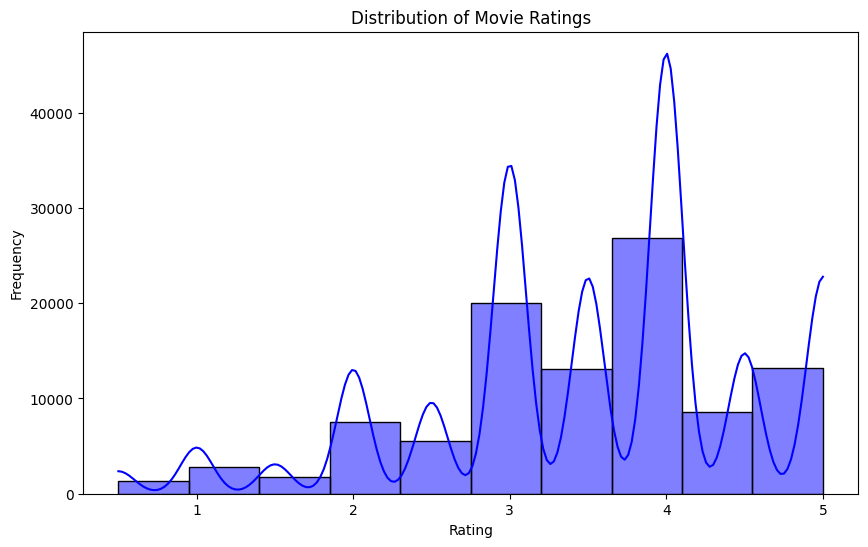

In [48]:
#Step 1: Visualize the Rating Distribution
import matplotlib.pyplot as plt
import seaborn as sns

# Rating distribution
plt.figure(figsize=(10, 6))
sns.histplot(ratings_df['rating'], bins=10, kde=True, color='blue')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


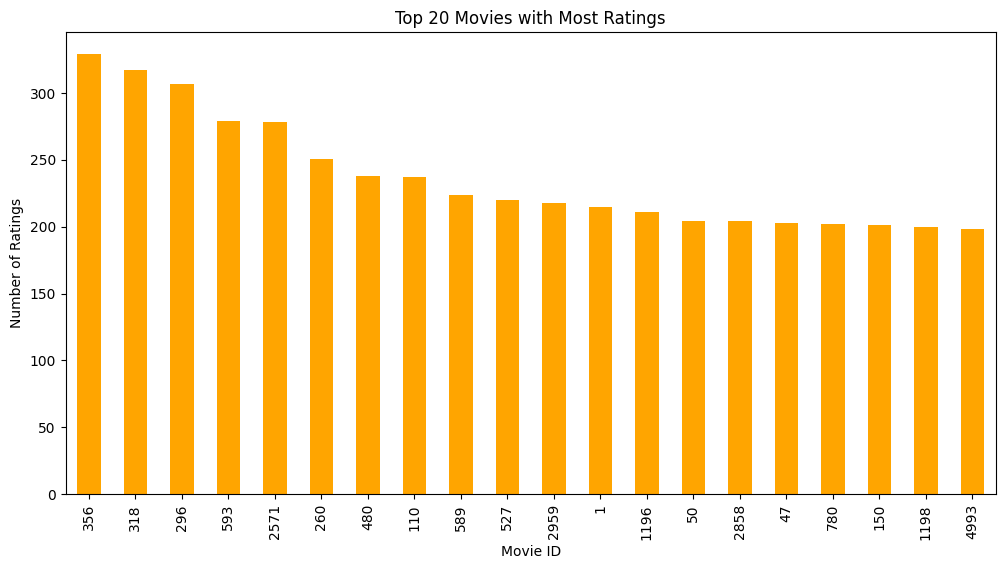

In [49]:
#Step 3: Visualize the Average Ratings per Movie
# Number of ratings per movie
ratings_per_movie = ratings_df.groupby('movieId').size().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
ratings_per_movie.head(20).plot(kind='bar', color='orange')
plt.title('Top 20 Movies with Most Ratings')
plt.xlabel('Movie ID')
plt.ylabel('Number of Ratings')
plt.show()


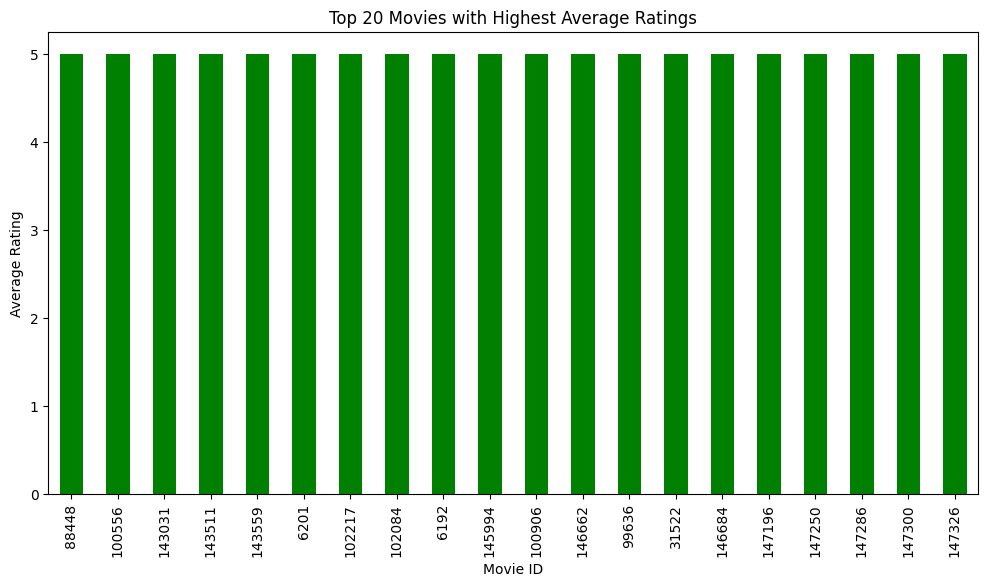

In [50]:
#Step 3: Visualize the Average Ratings per Movie
# Average ratings per movie
avg_ratings = ratings_df.groupby('movieId')['rating'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
avg_ratings.head(20).plot(kind='bar', color='green')
plt.title('Top 20 Movies with Highest Average Ratings')
plt.xlabel('Movie ID')
plt.ylabel('Average Rating')
plt.show()


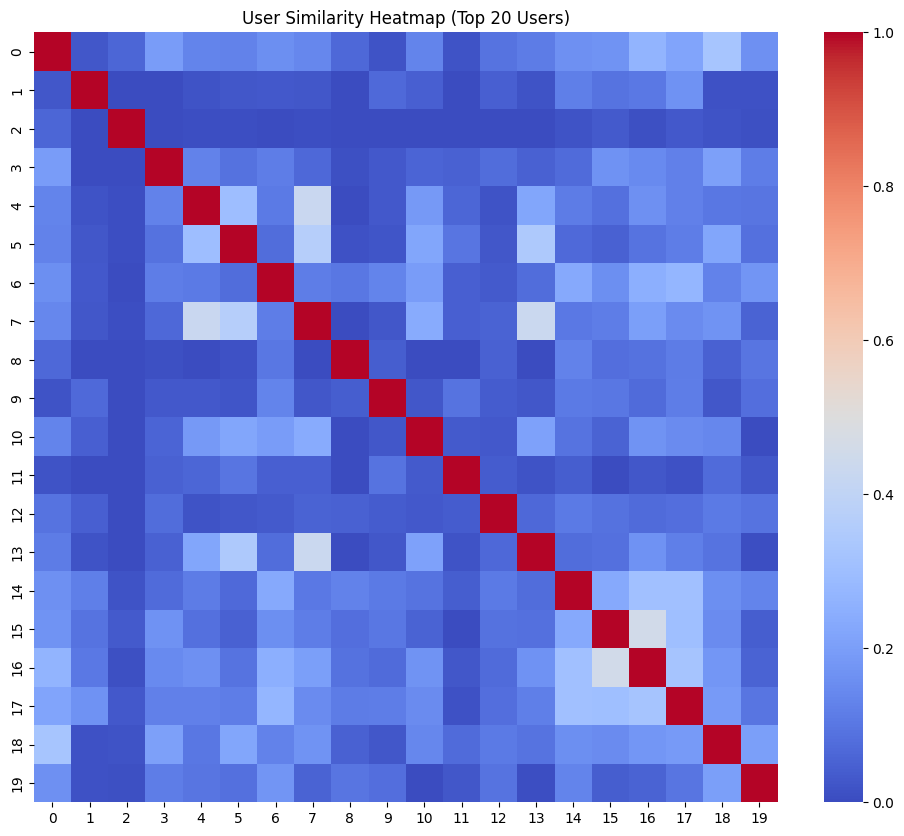

In [51]:
#Step 4: User Similarity Heatmap (Collaborative Filtering)
# Heatmap for user similarity
plt.figure(figsize=(12, 10))
sns.heatmap(user_similarity[:20, :20], cmap='coolwarm', annot=False)
plt.title('User Similarity Heatmap (Top 20 Users)')
plt.show()


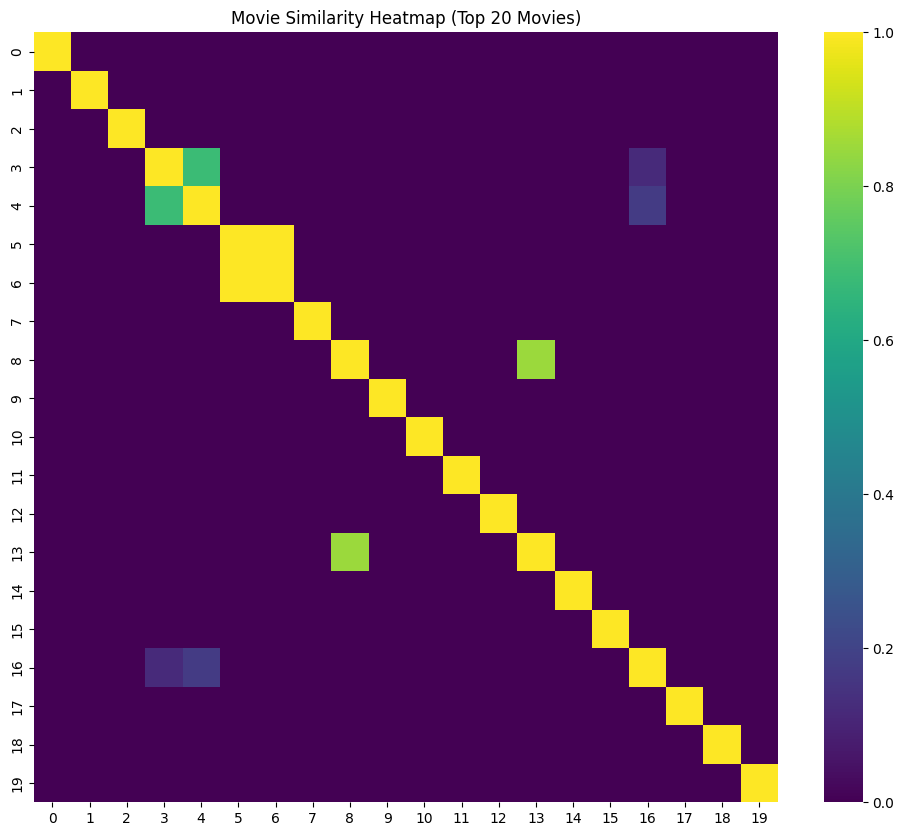

In [52]:
#Step 5: Movie Similarity Heatmap (Content-Based Filtering)
# Heatmap for movie similarity
subset_movies = content_similarity[:20, :20]  # First 20 movies
plt.figure(figsize=(12, 10))
sns.heatmap(subset_movies, cmap='viridis', annot=False)
plt.title('Movie Similarity Heatmap (Top 20 Movies)')
plt.show()


<ipython-input-55-b7002983e139>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=rmse_values, palette='viridis')


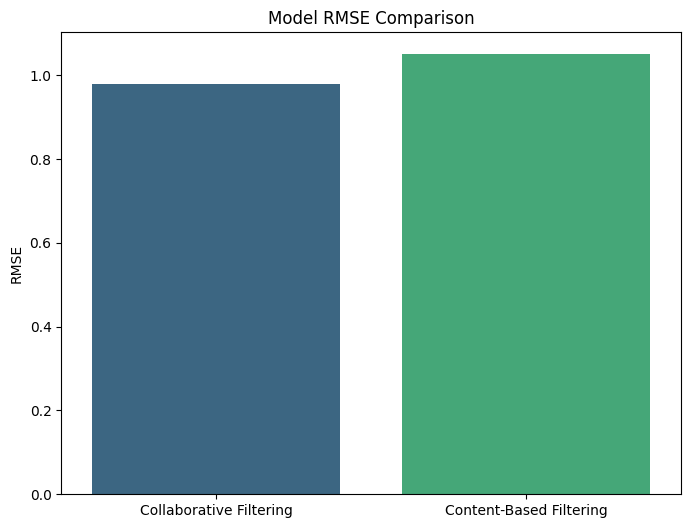

In [55]:
#Step 6: RMSE Comparison Visualization
# Example: RMSE comparison for different models
models = ['Collaborative Filtering', 'Content-Based Filtering']
rmse_values = [0.98, 1.05]  # Example RMSE values

plt.figure(figsize=(8, 6))
sns.barplot(x=models, y=rmse_values, palette='viridis')
plt.title('Model RMSE Comparison')
plt.ylabel('RMSE')
plt.show()


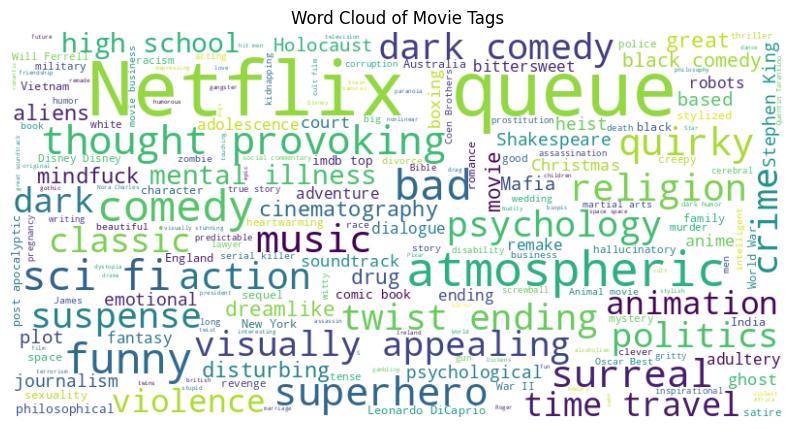

In [54]:
#Step 7: Tag Cloud for Movie Tags
from wordcloud import WordCloud

# Combine all tags into a single string
all_tags = ' '.join(tags_df['tag'].dropna())

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tags)

# Display word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Movie Tags')
plt.show()
